# Inpainting with Interpolation

In [45]:
# imports
import os
import numpy as np 

from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata
import h5py

from ulmo import io as ulmo_io
from ulmo.mae import enki_utils
from ulmo.plotting import plotting
from ulmo.mae import patch_analysis
from ulmo.mae import cutout_analysis

In [16]:
sst_path = os.getenv('OS_SST')
ogcm_path = os.getenv('OS_OGCM')
enki_path = os.path.join(os.getenv('OS_OGCM'), 'LLC', 'Enki')

# Load a cutout

In [19]:
valid_tbl_file = os.path.join(enki_path, 'Tables',
                              'Enki_LLC_valid_nonoise.parquet')
valid_img_file = os.path.join(enki_path, 'PreProc',
                              'Enki_LLC_valid_nonoise_preproc.h5')

In [20]:
# Load
t,p = 10,10
tbl = ulmo_io.load_main_table(valid_tbl_file)
#bias = enki_utils.load_bias((t,p))
bias = 0.

# Pick one
LL = 0.
imin = np.argmin(np.abs(tbl.LL - LL))
cutout = tbl.iloc[imin]

# Load the images
recon_file = enki_utils.img_filename(t,p, local=True)
mask_file = enki_utils.mask_filename(t,p, local=True)

f_orig = h5py.File(valid_img_file, 'r')
f_recon = h5py.File(recon_file, 'r')
f_mask = h5py.File(mask_file, 'r')

orig_img = f_orig['valid'][cutout.pp_idx, 0, :, :]
recon_img = f_recon['valid'][cutout.pp_idx, 0, :, :]
mask_img = f_mask['valid'][cutout.pp_idx, 0, :, :]

Read main table: /home/xavier/Projects/Oceanography/OGCM/LLC/Enki/Tables/Enki_LLC_valid_nonoise.parquet


## Show it

<Axes: >

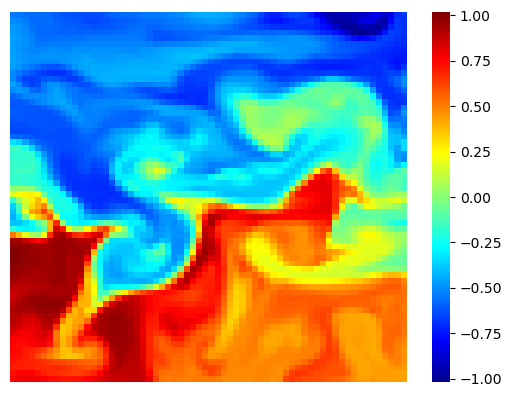

In [22]:
plotting.show_image(orig_img)

## Find the patches

In [27]:
p_sz = 4
patches = patch_analysis.find_patches(mask_img, p_sz)
#patches[0:3]
# Unravel
ij_patches = []
for patch in patches:
    i, j = np.unravel_index(patch, mask_img.shape)
    ij_patches.append((i,j))
ij_patches[0:2]

[(0, 4), (0, 12)]

# Generate the points

## Unmasked

In [32]:
unmasked = np.where(mask_img == 0)
x_pts = unmasked[0]
y_pts = unmasked[1]
vals = orig_img[unmasked]

## All

In [69]:
#all_x, all_y = np.mgrid[0:63:64j, 0:63:64j]
all_x, all_y = np.meshgrid(np.arange(64), np.arange(64), indexing='ij')

In [70]:
all_x

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  2,  2, ...,  2,  2,  2],
       ...,
       [61, 61, 61, ..., 61, 61, 61],
       [62, 62, 62, ..., 62, 62, 62],
       [63, 63, 63, ..., 63, 63, 63]])

# griddata

## Nearest

In [71]:
recon_nearest = griddata((x_pts, y_pts), vals, (all_x, all_y), method='nearest')

<Axes: >

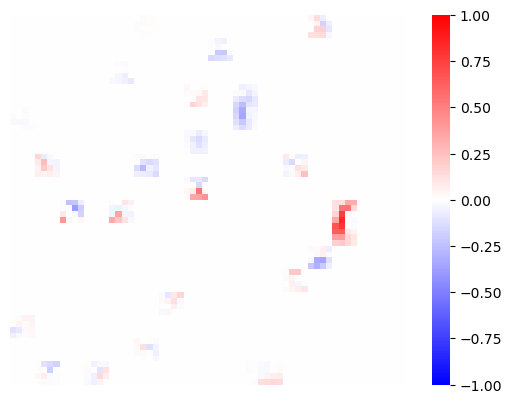

In [72]:
plotting.show_image(recon_nearest-orig_img, vmnx=(-1.,1.), cm='bwr')

In [73]:
rmse_nearest = cutout_analysis.rms_single_img(orig_img, recon_nearest, mask_img)
rmse_nearest

0.17028040189965687

## Linear

In [48]:
recon_linear = griddata((x_pts, y_pts), vals, (all_x, all_y), method='linear')

<Axes: >

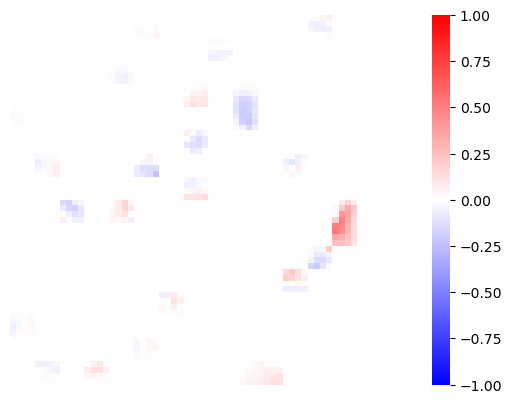

In [49]:
plotting.show_image(recon_linear-orig_img, vmnx=(-1.,1.), cm='bwr')

In [50]:
rmse_linear = cutout_analysis.rms_single_img(orig_img, recon_linear, mask_img)
rmse_linear

0.12193006302671183

## Cubic

In [51]:
recon_cubic = griddata((x_pts, y_pts), vals, (all_x, all_y), method='cubic')

<Axes: >

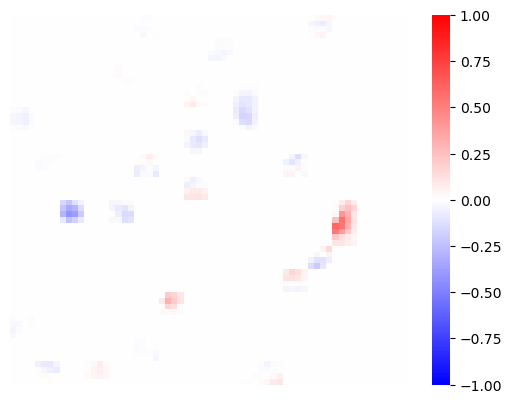

In [52]:
plotting.show_image(recon_cubic-orig_img, vmnx=(-1.,1.), cm='bwr')

In [53]:
rmse_cubic = cutout_analysis.rms_single_img(orig_img, recon_cubic, mask_img)
rmse_cubic

0.12086639578999377

----

# Debuggin

In [74]:
import h5py

## Load

In [75]:
biharm = os.path.join(enki_path, 'Recon', 'Enki_LLC2_nonoise_biharmonic_t10_p10.h5')
f_biharm = h5py.File(biharm, 'r')

In [76]:
nearest = os.path.join(enki_path, 'Recon', 'Enki_LLC2_nonoise_grid_nearest_t10_p10.h5')
f_nearest = h5py.File(nearest, 'r')

In [86]:
idx = 2000
b0 = f_biharm['inpainted'][idx,...]
n0 = f_nearest['inpainted'][idx,...]

<Axes: >

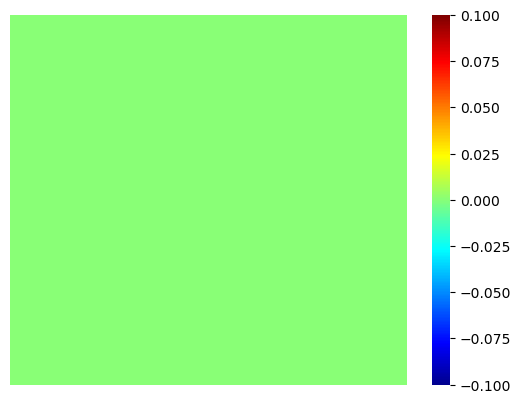

In [87]:
plotting.show_image(b0)

In [88]:
n0

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [85]:
f_biharm['inpainted'].shape

(655770, 64, 64)